# DSC 640 Weeks 9 & 10

## Arbaz Khan

My name is Arbaz Khan, and I am a member of the FAA statisical analysis team. For this project, I will be delving into the database of TSA-related complaints throughout the USA to find which states have the highest degree of complaints, and the source of these complaints. In order to effectively tackle this issue, we will be looking at which states have the highest rate of complaints, and attempt to find out what category of complaints occur most frequently. We will be combining the IATA/ICAO datasets alongside a variety of complaint datasets to create visualizations of complaints across the continental US, and to find out where we should focus our efforts to most efficiently improve flights throughout the US.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

df1 = pd.read_csv('compAir.csv')
df2 = pd.read_csv('compCat.csv')
df3 = pd.read_csv('compSub.csv')
df4 = pd.read_csv('iataIcao.csv')

df1

,pdf_report_date,airport,year_month,count
0,2019-02,ABE,2015-01,0
1,2019-02,ABE,2015-02,0
2,2019-02,ABE,2015-03,0
3,2019-02,ABE,2015-04,0
4,2019-02,ABE,2015-05,2
...,...,...,...,...
41716,2024-02,NaN,2023-09,4150
41717,2024-02,NaN,2023-10,3805
41718,2024-02,NaN,2023-11,2659
41719,2024-02,NaN,2023-12,3658


Now, we will merge df1 (complaints by airport) with df4 (the IATA/ICAO dataset) to gain access to latitude and longitude data alongside complaint counts

In [18]:
df1WithLat = df1.merge(df4, left_on = 'airport', right_on = 'iata', how = 'left')

df1WithLat = df1WithLat.dropna(subset=['latitude', 'longitude'])

Now, let's aggregate the data based on location

In [19]:
agg = df1WithLat.groupby(['airport_x', 'latitude', 'longitude'])['count'].sum().reset_index()

In [20]:
import folium
from folium.plugins import HeatMap

# Start map at the USA
m = folium.Map(location=[39, -95], zoom_start=3)

# Reformatting data by longitude and latitude with count 
# for usage in a heatmap
heat_data = [[row['latitude'], row['longitude'], row['count']] for _, row in agg.iterrows()]

HeatMap(heat_data, radius=15).add_to(m)
m.save('airport_complaints_heatmap.html')
m

To further investigate the rate of complaints within the US with a higher degree of specificity, let's re-aggregate our data and create a new HeatMap that 

In [21]:
import geopandas as gpd
from shapely.geometry import Point

# Utilize GeoJSON to convert lat/long into state
us_states = gpd.read_file('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json')

# Create geometry column in merged dataset
geometry = [Point(xy) for xy in zip(df1WithLat['longitude'], df1WithLat['latitude'])]
geo_df = gpd.GeoDataFrame(df1WithLat, geometry=geometry, crs="EPSG:4326")

# Now, we can use gpd.sjoin to join our data based on the lat/long 
# coordinates for each state, creating a 'name' column that gives the 
# name of the state that the row is contained within
geo_df = gpd.sjoin(geo_df, us_states, how='inner', predicate='within')

In [22]:
# Now, we group by state (name in this case) and sum the count of complaints
# for each state to create an aggregate dataset
aggState = geo_df.groupby('name')['count'].sum().reset_index()

aggState.columns = ['state', 'totalComplaints']

In [23]:
import folium

m = folium.Map(location=[39, -95], zoom_start=3)

folium.Choropleth(
    geo_data='https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json',
    name='choropleth',
    data=aggState,
    columns=['state', 'totalComplaints'],
    key_on='feature.properties.name',
    legend_name='Total Complaints per State'
).add_to(m)

m.save("state_complaints_choropleth.html")
m

This chart represents the frequency of complaint submissions throughout time for the entirety of the US, aggregated by state. Darker colors represent a higher density of complaints, and lighter colors represent a lower density. What this graph does not show, however, is the relationship between the total number of complaints received and the state.

From this chart, it is apparent that California, Texas, and Florida have the highest density of complaint submissions out of all states within in the country. To delve deeper into this data, we can additionally note the total number of complaints received by these top states, to discern which have the highest contribution to the total complaint totals.

In [24]:
# Merge data by complaints with IATA/IOCA dataset to find latitude/longitude data corresponding
# to each entry
df2 = df2.merge(df4, left_on='airport', right_on='iata', how='left')
df2 = df2.dropna(subset=['latitude', 'longitude'])  # Keep only valid airports

In [25]:
# Create geometry column
geometry = [Point(xy) for xy in zip(df1WithLat['longitude'], df1WithLat['latitude'])]
gdf = gpd.GeoDataFrame(df1WithLat, geometry=geometry, crs="EPSG:4326")

# Spatial join to assign state to each airport
gdf = gpd.sjoin(gdf, us_states, how='inner', predicate='within')  # now has `name` column = state

target_states = ['California', 'Texas', 'Florida']
gdf_filtered = gdf[gdf['name'].isin(target_states)]

# Sum complaints by state
complaints_by_state = gdf_filtered.groupby('name')['count'].sum().reset_index()
complaints_by_state.columns = ['state', 'totalComplaints']

Here, we will create a bar chart that showcases the difference in numerical frequencies for complaints for each state.

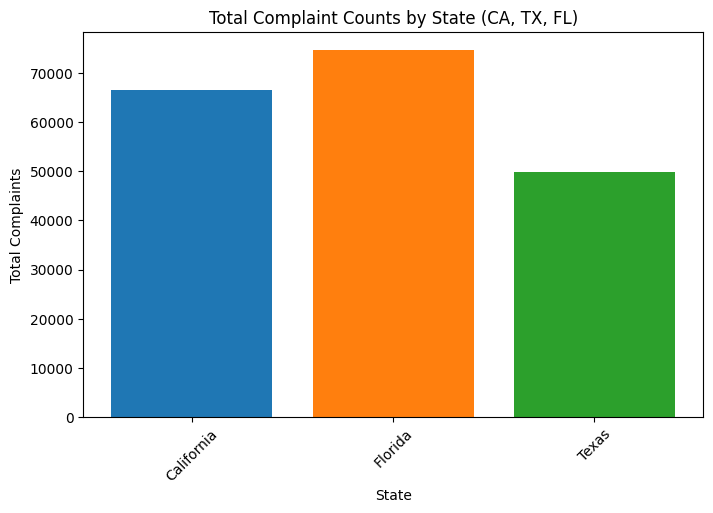

In [26]:
plt.figure(figsize=(8, 5))
plt.bar(complaints_by_state['state'], complaints_by_state['totalComplaints'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title("Total Complaint Counts by State (CA, TX, FL)")
plt.xlabel("State")
plt.ylabel("Total Complaints")
plt.xticks(rotation=45)
plt.show()

As shown in this graph, Florida and California have the highest frequency of complaint submissions.

Now, it would be helpful to discern which types of complaints occur the most in these states, so that we can pinpoint exactly where improvements can be made. This will allow us to not only target specific states, but to target specific goals in areas of improvement for these departments in the TSA.

In this pursuit, we can showcase some bar charts that demonstrate the frequency of the 5 most common complaint categories in the 2 states with the highest total complaints, which are Florida and California.

In [27]:
# Load US states
us_states = gpd.read_file('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json')

# Create geometry column
geometry = [Point(xy) for xy in zip(df2['longitude'], df2['latitude'])]
gdf = gpd.GeoDataFrame(df2, geometry=geometry, crs="EPSG:4326")

# Spatial join to assign state
gdf = gpd.sjoin(gdf, us_states, how='inner', predicate='within')

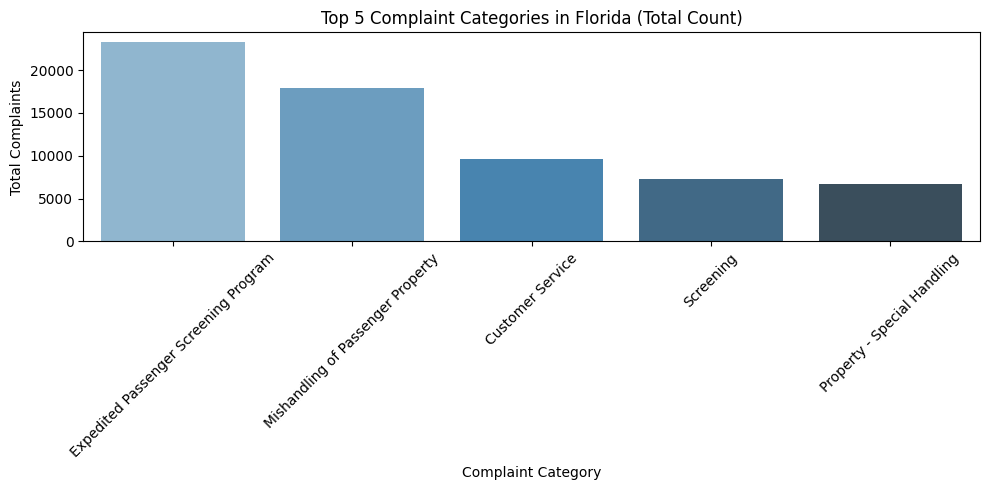

In [28]:
gdfFlorida = gdf[gdf['name'] == 'Florida']

# Group and get top 5 categories
top5 = (
    gdfFlorida.groupby('category')['count']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)

plt.figure(figsize=(10, 5))
sns.barplot(data=top5, x='category', y='count', palette='Blues_d')

plt.title("Top 5 Complaint Categories in Florida (Total Count)")
plt.xlabel("Complaint Category")
plt.ylabel("Total Complaints")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

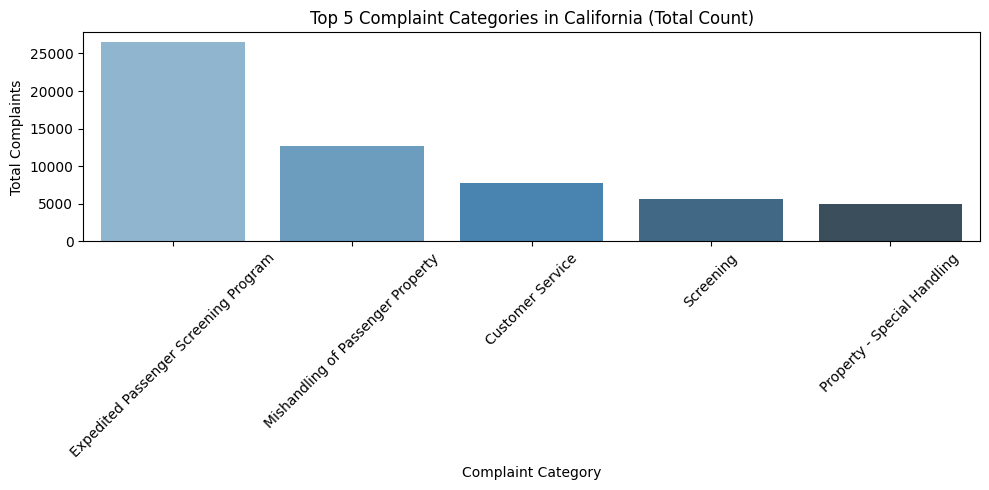

In [29]:
gdfCalifornia = gdf[gdf['name'] == 'California']

# Group and get top 5 categories
top5 = (
    gdfCalifornia.groupby('category')['count']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)

plt.figure(figsize=(10, 5))
sns.barplot(data=top5, x='category', y='count', palette='Blues_d')

plt.title("Top 5 Complaint Categories in California (Total Count)")
plt.xlabel("Complaint Category")
plt.ylabel("Total Complaints")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the above charts, we can see that both Florida and California have the highest number of complaints stemming from the Expedited Passenger Screening Program category. To further explore this issue, we can aggregate the data for all states and see to what degree this category dominates complaints, utilizing a box-and-whisker plot. This plot type will showcase not only which category has the most complaints, but also the general spread of each quartile so we can determine if the data has a large amount of skew, which could make this data less valid for the entirety of the US. 

C:\Users\Arbaz\AppData\Local\Temp\ipykernel_5040\4059907959.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2Top['logCount'] = np.log1p(df2Top['count'])


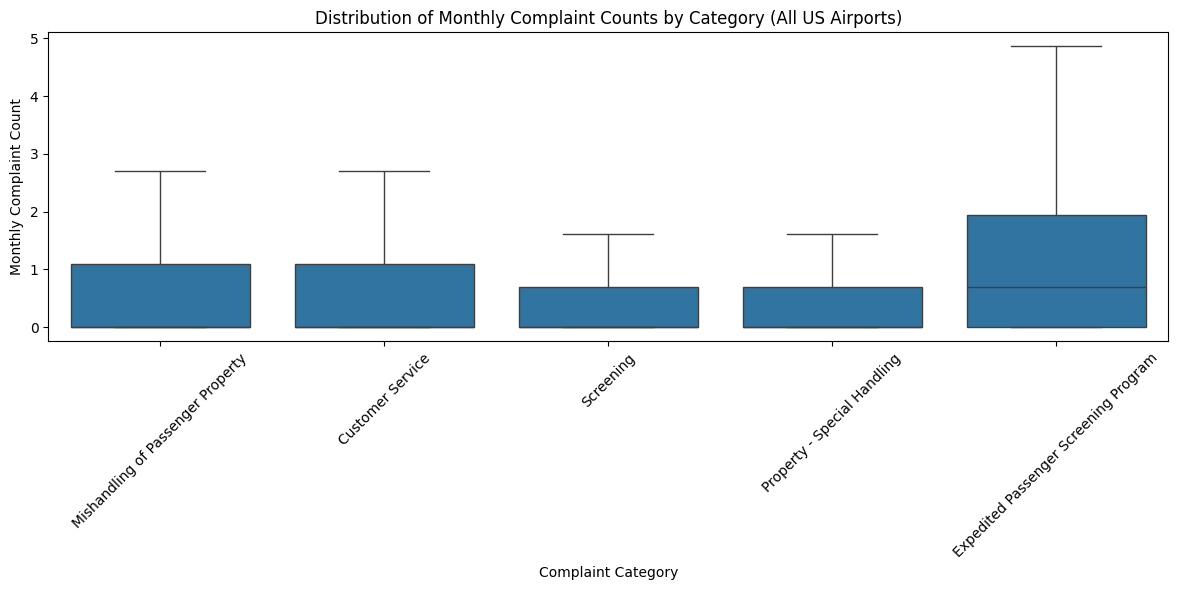

In [30]:
import matplotlib.pyplot as plt

# Step 1: Identify the top 10 most frequent categories by total complaint count
topCat = (
    df2.groupby('category')['count']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# Step 2: Filter the dataset to only include those top categories
df2Top = df2[df2['category'].isin(topCat)]

df2Top['logCount'] = np.log1p(df2Top['count'])

plt.figure(figsize=(12, 6))

sns.boxplot(data=df2Top, x='category', y='logCount', showfliers=False)

plt.title("Distribution of Monthly Complaint Counts by Category (All US Airports)")
plt.xlabel("Complaint Category")
plt.ylabel("Monthly Complaint Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This final plot showcases that Expedited Passenger Screening Programs are significantly higher contributors to the overall complaint network by a large margin. Not only is its median value far higher than the other 4 categories, but both the second and third quartiles for this datapoint are significantly higher than the corresponding ones in the other categories. This demonstrates how statistically significant these complaint categories are, and that they have an extremely noteworthy contribution to the overall total complaint volume.

As a result from these studies, my recommendations are as follows:
Firstly, focus should be placed on the states of Florida, California, and Texas, in that order, as they have the highest frequencies of complaints, as well as the highest density of complaints of all the states in the US.
In addition, throughout the US, as well as in California and Florida specifically, Expedited Passenger Screening Programs are the most significant source of these complaints.

Therefore, it would be in the FAA and TSA's best interested to look into this expedited screening program in order to make the most significant reduction to overall complaint volume in the entirety of the US. Narrowing our focus into these specific aspects would not only increase efficiency, but also likely have the largest contribution to fixing these complaints and making commercial aviation more comfortable throughout the US for all travelers.